In [37]:
%run imports/VacuumGauge_functions.ipynb
%run imports/rbflayer.py

import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.pipeline import Pipeline

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [38]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

In [39]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

## Hold out a test set for final evaluation

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


print(len(y_train))
print(sum(y_train))
print(len(y_test))
print(sum(y_test))

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN size: 222 TEST size: 56
222
111
56
28


### Definition of a StratifiedKFold split to be used on the train set in all the grid search for all the model: 

In [41]:
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
scaler = RowScaler('Standard')
# X_norm = scaler.fit_transform(X)
# X_norm[0].shape

i=100
X_train_m = scaler.fit_transform(X_train) - scaler.fit_transform(X_train).mean(axis=0, keepdims=0)
plt.figure()
plt.plot(range(3000), scaler.fit_transform(X_train)[i])
plt.plot(range(3000), X_train_m[i])
plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
X_train_pca[1]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fontsize=15

ok = X_train_pca[y_train==0]
delta = X_train_pca[y_train ==1]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('forest', RandomForestClassifier())

])

model = forest_clf
model_dir = 'data/models/random_forest'
model_version = 'forest_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

forest_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir,model_version))

### Quick train to get an overview of the model

In [ ]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
forest_clf.fit(X_train_forest, y_train_forest)
y_pred = forest_clf.predict(X_test_forest)
print(accuracy_score(y_true=y_test_forest, y_pred=y_pred, sample_weight=None))
print(recall_score(y_true=y_test_forest, y_pred=y_pred, sample_weight=None))

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'forest__n_estimators': range(100,200,20),
     'forest__max_leaf_nodes': range(3,8),
     'forest__bootstrap': [False],
    }
]


In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

In [ ]:
#printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

### Saving the model

In [ ]:
save_model(grid_search, model_dir, model_version)

## Logistic Regressor (classifier)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('logistic', LogisticRegression())

])

model = log_clf
model_dir = 'data/models/logistic_classifier'
model_version = 'logistic_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

log_path = os.path.join(model_dir, model_version)

print(os.path.join(model_dir, model_version))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
    }
]

In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

### Saving the model

In [ ]:
#print(grid_search)
save_model(grid_search, model_dir, model_version)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())

])

model = knn_clf
model_dir = 'data/models/knn'
model_version = 'knn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']

knn_path = os.path.join(model_dir, model_version)
print(os.path.join(model_dir, model_version))

In [ ]:
param_grid = [
    {'scaler__scaling_method': RowScaler().scaling_options,
     'pca__n_components': range(2,6),
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

In [ ]:
print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
grid_search.best_score_

In [ ]:
save_model(grid_search, model_dir, model_version)

## CNN 

In [6]:
print(X_train.shape)

(222, 3000)


Function that builds the CNN for the gridsearch. Each layer is a Con1d and a maxpool. Each layer reduce the second axis dimension of a factor 2.

In [28]:
keras.backend.clear_session()

def rowScale(X):
    mean = tf.reshape(tf.reduce_mean(X, axis=1), [-1, 1])
    std =  tf.reshape(tf.math.reduce_std(X, axis=1), [-1, 1])
    return (X - mean)/std

def build_CNN(filters=15, kernel_size=20, learning_rate=0.001, layers=1):
    model = keras.models.Sequential()
    model.add(keras.layers.Lambda(lambda X: rowScale(X), input_shape=[3000]))
    model.add(keras.layers.Reshape((3000, 1)))

    for l in range(layers):
        model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                    activation='relu', padding='same', use_bias=True))
        model.add(keras.layers.MaxPool1D(pool_size=2, padding='valid'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=100, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[keras.metrics.Recall()])
    return model
class_weight = {0: 1.,
                1: 50.}
model = build_CNN(layers=1)
model.summary()
# history = model.fit(X_train, y_train, epochs=5, class_weight=class_weight, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3000)              0         
_________________________________________________________________
reshape (Reshape)            (None, 3000, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3000, 15)          315       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1500, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 22500)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2250100   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

In [ ]:
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_CNN)

model = cnn_clf
model_dir = 'data/models/cnn'
model_version = 'cnn_001.pkl'
scoring = ['recall', 'accuracy', 'precision']


In [ ]:
param_grid = [
    {'layers': [1,2,3],
    }
]

In [ ]:
keras.backend.clear_session()

print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring=scoring,
    n_jobs=-1,
    verbose=1, 
    cv=strat_kfold, 
    return_train_score=True,
    refit=scoring[0]  ## Score used for final refit
)

grid_search.fit(X_train, y_train, epochs=20)

In [ ]:
printGridSearchResults(grid_search, scoring[0])

In [ ]:
a = np.array(range(30)).reshape(6,5)
print(a)
print(a.T)
print((a- np.mean(a, axis=1).reshape(-1,1))/np.std(a, axis=1).reshape(-1,1))
np.mean(a, axis=1).T

In [ ]:
layer = keras.layers.Lambda(lambda X: (X - tf.reshape(tf.reduce_mean(X, axis=1), [-1, 1]))/tf.reshape(tf.math.reduce_std(X, axis=1), [-1,1]), dtype=tf.float32)
output = layer(X_train)
print(output)

In [ ]:
scaler = RowScaler(scaling_method='Standard')
i = 0
plt.plot(range(3000), output[i])
plt.show()

plt.plot(range(3000), scaler.fit_transform(X_train)[i])
plt.show()

plt.plot(range(3000), ((X_train[i] - np.mean(X_train[i]))/np.std(X_train[i])))
plt.show()

In [ ]:
mean, var = tf.nn.moments(tf.constant(a), axes=[1])
print(tf.reshape(mean, [-1,1]))
print(var)

In [ ]:
# y_pred = grid_search.best_estimator_.predict(X_test)

# from sklearn.metrics import recall_score, precision_score, accuracy_score

# recall_score(y_test, y_pred)

## RBF

In [50]:
df_raw = df_raw[df_raw.fillNumber != 2011]

df_raw = df_raw.astype({'fillNumber': 'int'})
df_raw = df_raw.set_index(['gauge_id','fillNumber'], drop=True)
df_raw.index.get_level_values('fillNumber').value_counts()

5979    808
5980    806
2010    676
2025    673
2009    673
2022    672
2216    672
2040    670
Name: fillNumber, dtype: int64

In [53]:
from sklearn.cluster import KMeans


scaler = RowScaler(scaling_method='Standard')
X_scaled = scaler.fit_transform(df_raw)

In [57]:
X_scaled = scaler.fit_transform(df_raw)

kmeans_per_k = [KMeans(n_clusters=k,
                                  algorithm='elkan',
                                  random_state=42,
                                  n_jobs=-1
                                  ).fit(X_scaled)
                for k in range(5, 20, 5)]

inertias = [model.inertia_ for model in kmeans_per_k]

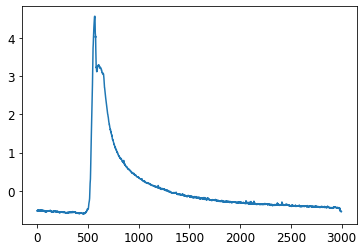

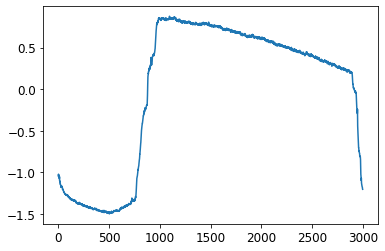

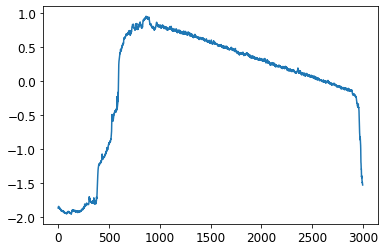

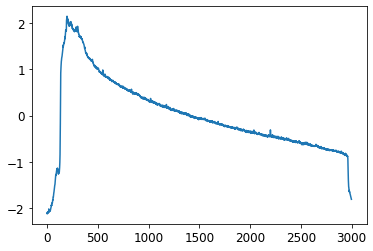

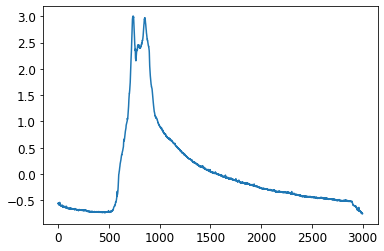

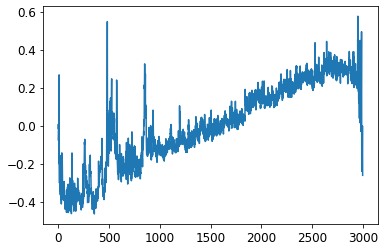

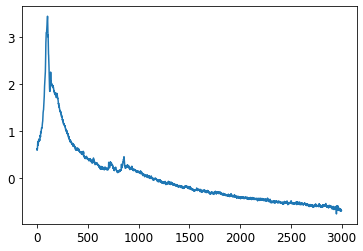

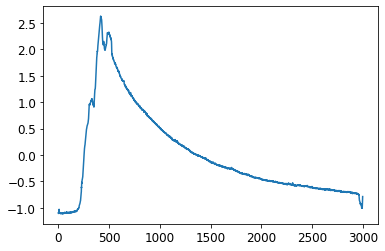

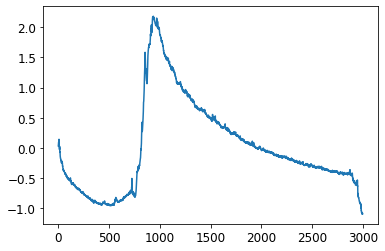

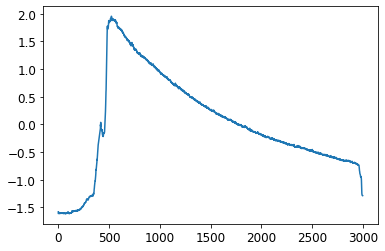

In [62]:
for c in kmeans_per_k[1].cluster_centers_:
    plt.plot(range(3000), c)
    plt.show()

In [49]:
model = keras.models.Sequential()
model.add(RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=1.0,
                    trainable=False,
                    input_shape=[3000])
                    )
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_6 (RBFLayer)       (None, 10)                30010     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 30,021
Trainable params: 11
Non-trainable params: 30,010
_________________________________________________________________


In [ ]:
domande:
devo abilitare il training sul layer RBF?
definire modelli finali
train - val- test split, va bene?
quante fold nel k fold?
perche RNN cosi lenta?